In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

# Display entire Scenario string in notebook
pd.options.display.max_colwidth = 4000

In [2]:
# Read data from Excel
columns_from_excel = "F,KC,KD,KE,KU,LE"
column_headers = ["scenarios", "cash_delta", "finance_delta", "lease_delta", "spend_delta", "lift_delta"]

df = pd.read_excel(r'C:\Users\bryant.vu\Documents\Python_Scripts\2019.11.04 - DSS - v4.7.2 - 7 block - Mitsu MY19 v4.xlsm', sheet_name="Calc", names=column_headers, skiprows=499, nrows=500, usecols=columns_from_excel)

In [3]:
# Remove (#) and spaces at beginning and end of Scenario
df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

In [4]:
# Create delta_spend columns in data
# Note: need to add user input baseline (currently controlled in if index % 500 == x)
delta_columns = ["cash_delta", "finance_delta", "lease_delta","spend_delta","lift_delta"]
for x in delta_columns:
    baseline = 0
    df_delta = []
    if x == 'lift_delta':
        for index, row in df.iterrows():
            if index % 500 == 11:
                baseline = row[x]
            try:
                delta = row[x]/baseline - 1
                df_delta.append(delta)
            except:
                delta = row[x] - baseline
                df_delta.append(delta)
    else:
        for index, row in df.iterrows():
            if index % 500 == 11:
                baseline = row[x]
            delta = row[x] - baseline
            df_delta.append(delta)
    df[x] = df_delta

# Create no_of_moves column
no_of_moves = 0
df_no_of_moves = []

for index, row in df.iterrows():
    no_of_moves = str(row['scenarios']).count('\n') + 1
    df_no_of_moves.append(no_of_moves)
    
df['no_of_moves'] = df_no_of_moves

In [ ]:
# Find efficiency frontier (only model #1 so far)
df_length = df.shape[0]
eff_frontier = pd.DataFrame()

for i in range(0,500,500):
    for k in range(13,500):
        current_spend = df['spend_delta'][k + i]
        current_lift = df['lift_delta'][k + i]
        for j in range(13,500):
            new_spend = df['spend_delta'][j + i]
            new_lift = df['lift_delta'][j + i]
            if (new_spend < current_spend) & (new_lift > current_lift):
                break
            elif (np.isnan(df['spend_delta'][j + i])) & (j == 499):
                if np.isnan(df['spend_delta'][k + i]):
                    continue
                else:
                    eff_frontier = eff_frontier.append(df.iloc[[k+i]])

# Drop N/As
eff_frontier = eff_frontier.dropna()

In [ ]:
# Set spend boundaries
eff_frontier = eff_frontier[(eff_frontier['spend_delta'] > -200)]
eff_frontier = eff_frontier[(eff_frontier['spend_delta'] < 600)]

In [ ]:
# Plot efficiency frontier 
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=eff_frontier['spend_delta'], y=eff_frontier['lift_delta'], s=400)
p2 = sns.regplot(x=eff_frontier['spend_delta'], y=eff_frontier['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for i in range(eff_frontier.shape[0]):
    p1.text(eff_frontier['spend_delta'].iloc[i]+2, eff_frontier['lift_delta'].iloc[i], i, size=60)

In [ ]:
eff_frontier.sort_values('spend_delta')
eff_frontier['row_no'] = [i for i in range(eff_frontier.shape[0])]

eff_frontier

# Remove extraneous scenarios

In [ ]:
# Remove single lever moves (add user option in later)
eff_frontier['lift/spend'] = eff_frontier['lift_delta'] / eff_frontier['spend_delta']
eff_frontier = eff_frontier[eff_frontier['no_of_moves'] > 1].sort_values('spend_delta')

# Reduce APR moves with std
reg_ex = "std"
reg_ex_filter = eff_frontier['scenarios'].str.contains(reg_ex)
eff_frontier = eff_frontier[~reg_ex_filter]

# Remove +CC and -APR moves
reg_ex = "APR"
reg_ex_filter = eff_frontier['scenarios'].str.contains(reg_ex)
eff_frontier['cash_finance_sum'] = round(eff_frontier['cash_delta']/50.0)*50 + round(eff_frontier['finance_delta']/50.0)*50
cash_finance_sum_filter = eff_frontier['cash_finance_sum'] == 0

eff_frontier = eff_frontier[~(reg_ex_filter & cash_finance_sum_filter)]

In [ ]:
# Find best fit line
xs = p1.get_lines()[0].get_xdata()
ys = p1.get_lines()[0].get_ydata()

xs_delta = xs - xs.mean()
ys_delta = ys - ys.mean()
xs_times_ys = xs_delta * ys_delta
xs_squared = xs_delta * xs_delta

m = xs_times_ys.sum() / xs_squared.sum()
b = ys.mean() - m*xs.mean()

eff_frontier['y_line'] = eff_frontier['spend_delta']*m+b
eff_frontier = eff_frontier[eff_frontier['lift_delta'] > eff_frontier['y_line']-0.01002]

In [ ]:
eff_frontier

# Create rankings

In [ ]:
def percent_max_col(df, series):
    max_of_col = df[series].max()
    new_col_name = 'percent_max_' + series
    df[new_col_name] = df[series]/ max_of_col

percent_max_col(eff_frontier, "spend_delta")

In [ ]:
eff_frontier

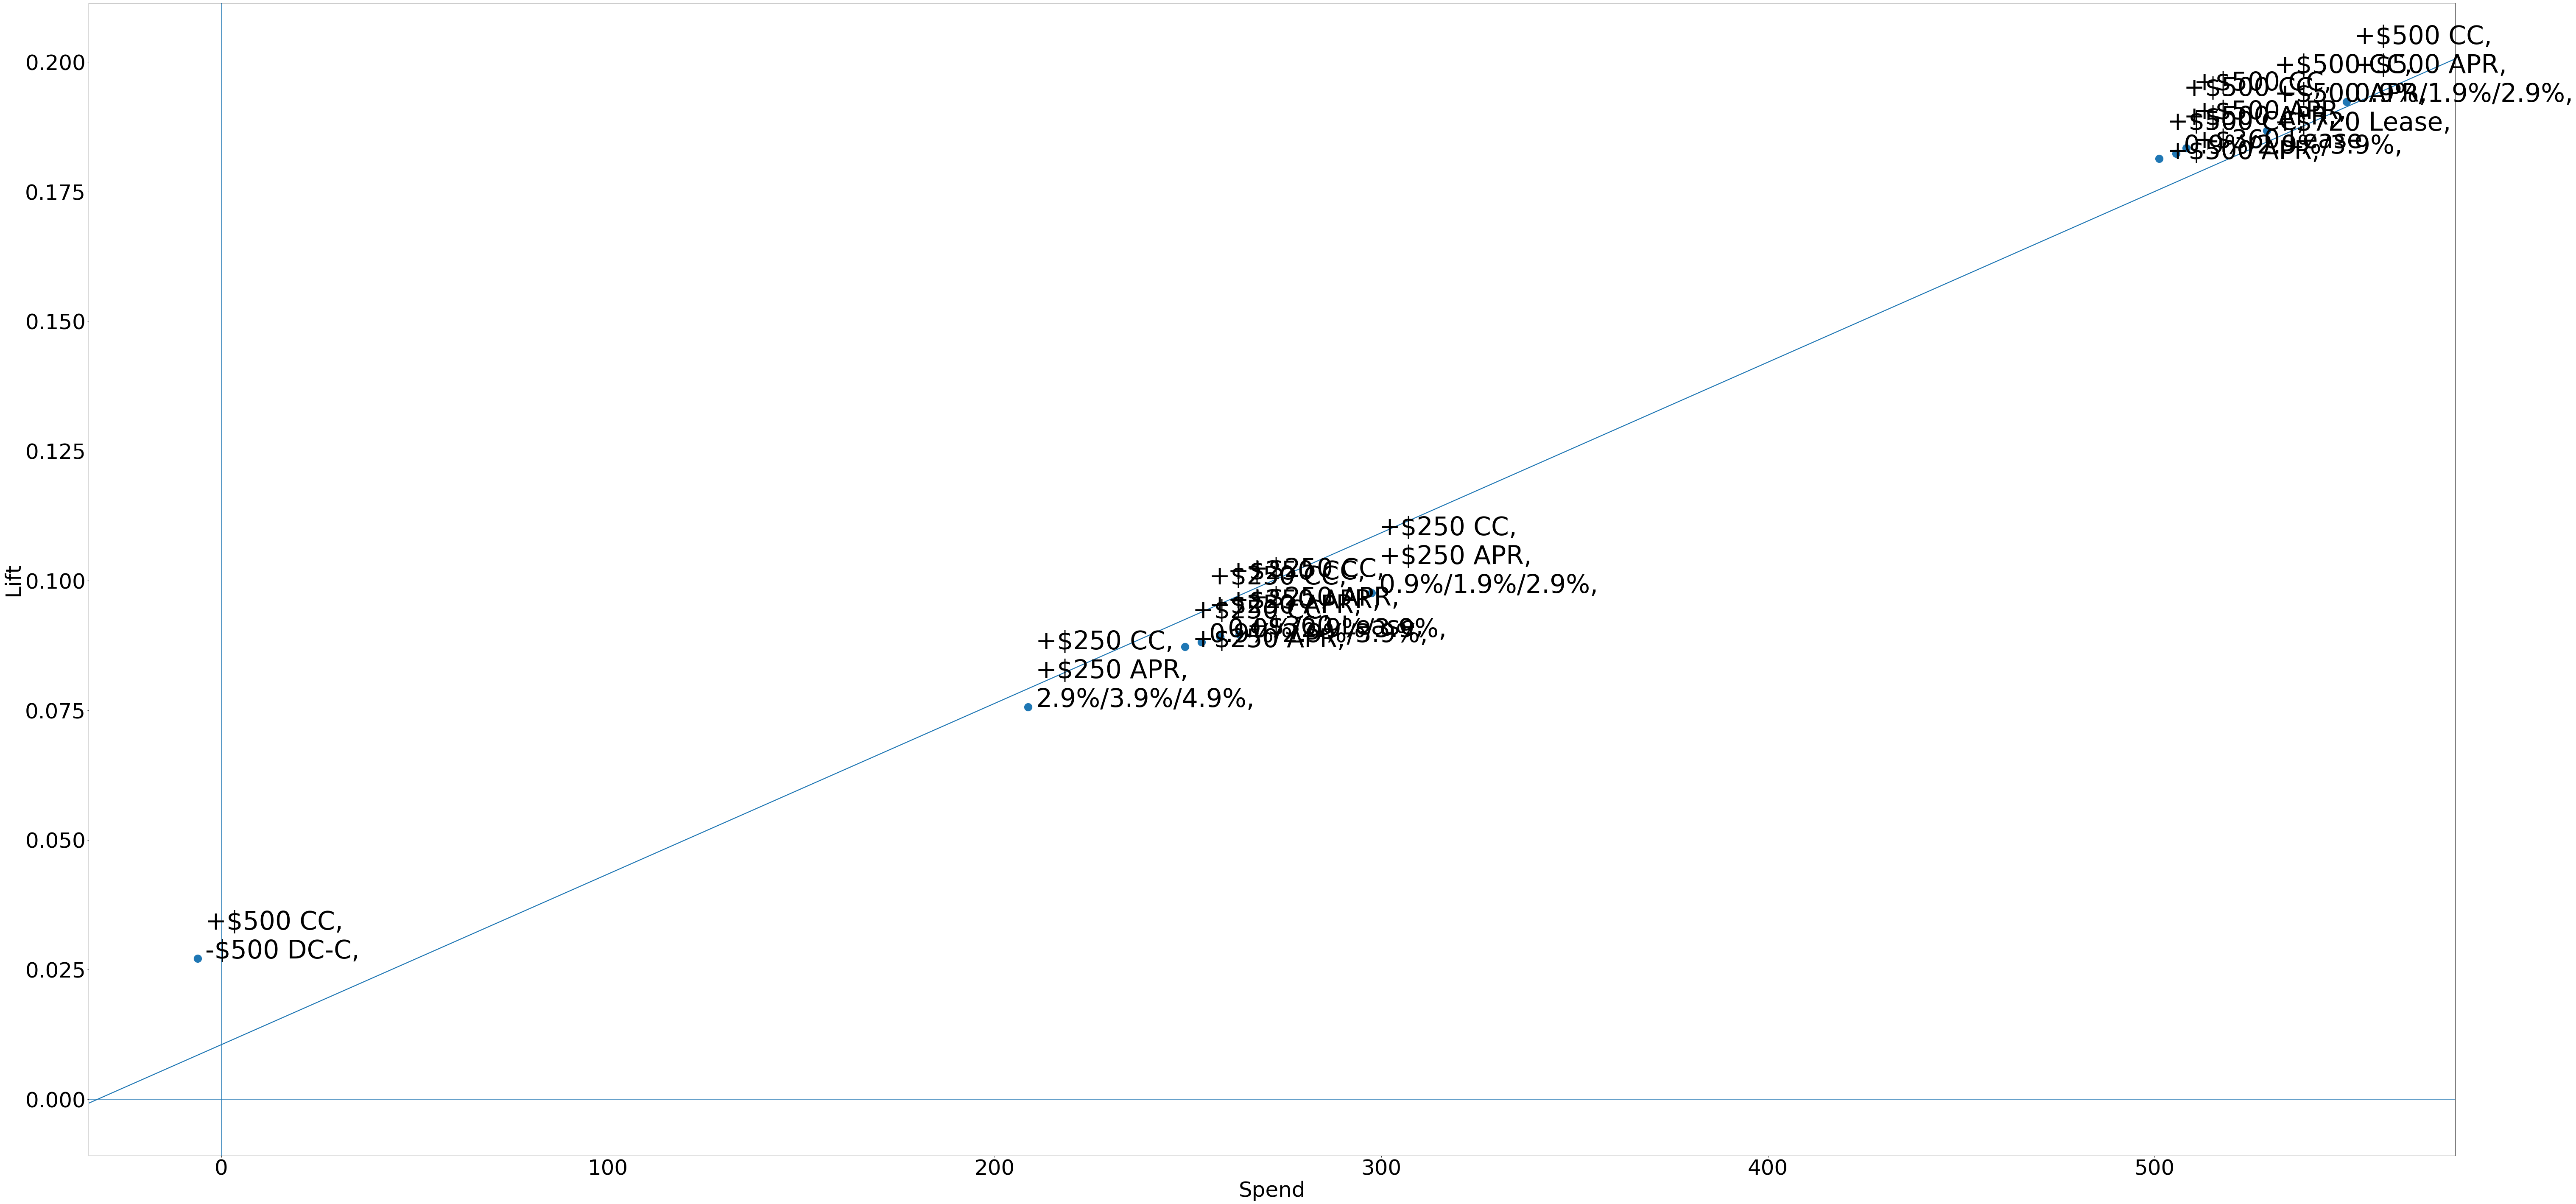

In [14]:
# Plot remaining scenarios above best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=eff_frontier['spend_delta'], y=eff_frontier['lift_delta'], s=400)
p2 = sns.regplot(x=eff_frontier['spend_delta'], y=eff_frontier['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, eff_frontier.shape[0]):
    p1.text(eff_frontier['spend_delta'].iloc[row]+2, eff_frontier['lift_delta'].iloc[row], eff_frontier['scenarios'].iloc[row], size=60)
      
plt.show()